<a href = "https://github.com/XinjianOUYANG/Pole_Projet_DDSP/blob/6d9ce46c5137bb2a513254845400dd499f41f323/showing_models_colab.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Showing the DDSP models we have trained


## Install Dependencies

In [6]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import glob
import os
import copy
import pickle

import ddsp
import ddsp.training
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import (play, record, 
    specplot, upload, DEFAULT_SAMPLE_RATE)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

ModuleNotFoundError: No module named 'google.colab'

## Upload audios and compute (f0,loudness,z)

### Using the given [python file](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in ddsp library to compute $f0$ and loudness.
* *ddsp.spectral_ops.compute_f0*

* *ddsp.spectral_ops.compute_loudness*

In [3]:
filenames, audios = upload()

NameError: name 'upload' is not defined

[array([[-6.1037019e-05,  0.0000000e+00,  3.0518509e-05, ...,
        -3.3570360e-04, -3.0518509e-04, -6.1037019e-05],
       [ 3.0518509e-05, -3.0518509e-05, -1.2207404e-04, ...,
        -3.0518509e-05,  3.0518509e-05, -2.1362957e-04]], dtype=float32)]
(1, 2, 3283905) (1, 160000)


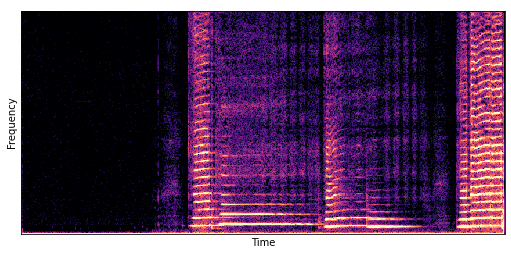

In [21]:
audio = audios[0][0][:160000] #the first 160000 frames(10 seconds)
audio = audio[np.newaxis,:]
print(audios)
print(np.shape(audios),np.shape(audio))

specplot(audio)
play(audio)

Text(0, 0.5, 'Loudness')

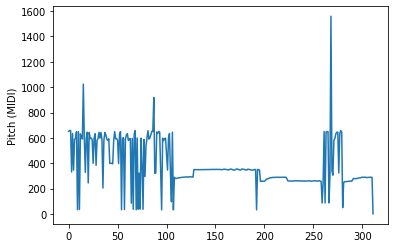

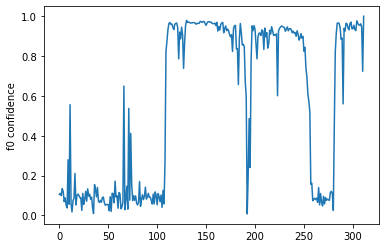

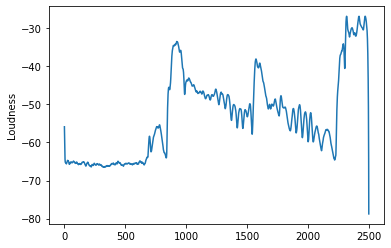

In [ ]:
# filenames, audios = upload()
# audio = audios[0]
# audio = audio[np.newaxis,:]

# specplot(audio)
# play(audio)

#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio[0], 
                                                       sample_rate=16000,
                                                       frame_rate=31.25,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio[0],
                     sample_rate=16000,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)

audio_features_key = ['audio','f0_hz','f0_confidence','loundness_db']
audio_features = dict([(k,[]) for k in audio_features_key])
audio_features['audio'] = audio
audio_features['f0_hz'] = f0_crepe
audio_features['f0_condience'] = f0_confidence
audio_features['loudness_db'] = loudness

# Plot Pitch/f0.
plt.figure(figsize=(6, 4))
f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
plt.plot(np.ravel(audio_features['f0_hz']), label='crepe')
plt.ylabel('Pitch (MIDI)')
# Plot f0_confidence.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(audio_features['f0_condience']), label='f0 confidence')
plt.ylabel('f0 confidence')
# Plot Loundness.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(audio_features['loudness_db']), label='loudness')
plt.ylabel('Loudness')



### Compute z/MFCC

* training withou z encoder [solo_instrument.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/solo_instrument.gin)
* training with z encoder [ae.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/ae.gin)



<img src="https://drive.google.com/uc?export=view&id=1E-KntALWa0_fFSwL2JaJicEPv2yif7Zz" alt="Diagram of the z-encoder" width="700">

* [z encoder](https://github.com/magenta/ddsp/blob/master/ddsp/training/encoders.py) and [MFCC computing file](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in DDSP library
* *ddsp.spectral_ops.compute_mfcc*

Text(0, 0.5, 'MFCC')

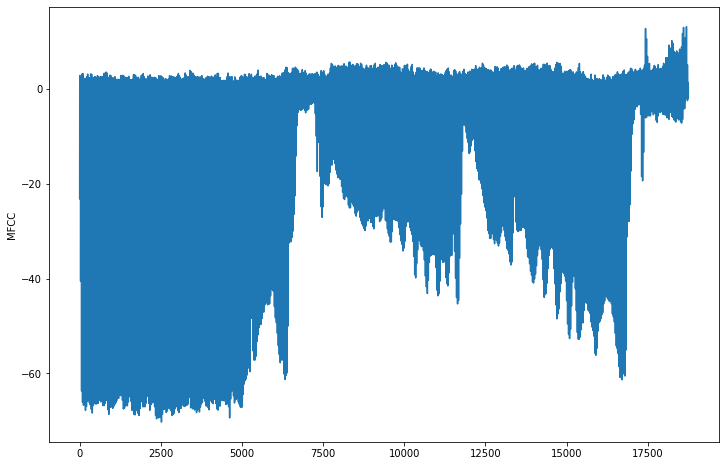

In [ ]:
#Calculate MFCC(Mel-frequency Cepstral Coefficients)
mfccs = ddsp.spectral_ops.compute_mfcc(
    audio[0],
    lo_hz=20.0,
    hi_hz=8000.0,
    fft_size=1024,
    mel_bins=128,
    mfcc_bins=30)

# Plot MFCC.
plt.figure(figsize=(12, 8))
plt.plot(np.ravel(mfccs), label='MFCC')
plt.ylabel('MFCC')


### Another way to compute f0 and loudness

In [ ]:
# # Setup the session.
# ddsp.spectral_ops.reset_crepe()

# # Compute features.
# audio_features = ddsp.training.metrics.compute_audio_features(audio[0])
# audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
# audio_features_mod = None

# TRIM = -15
# # Plot Features.
# fig, ax = plt.subplots(nrows=3, 
#                        ncols=1, 
#                        sharex=True,
#                        figsize=(6, 8))
# ax[0].plot(audio_features['loudness_db'][:TRIM])
# ax[0].set_ylabel('loudness_db')

# ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
# ax[1].set_ylabel('f0 [midi]')

# ax[2].plot(audio_features['f0_confidence'][:TRIM])
# ax[2].set_ylabel('f0 confidence')
# _ = ax[2].set_xlabel('Time step [frame]')

## Load the model(without z encoder)

In [ ]:
def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir

UPLOAD_DIR = '/content/uploaded'
!mkdir $UPLOAD_DIR
uploaded_files = files.upload()

for fnames in uploaded_files.keys():
  print("Unzipping... {}".format(fnames))
  !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
model_dir = find_model_dir(UPLOAD_DIR)
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

mkdir: cannot create directory ‘/content/uploaded’: File exists


Saving my_solo_instrument.zip to my_solo_instrument.zip
Unzipping... my_solo_instrument.zip


In [ ]:
# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)


Loading dataset statistics from /content/uploaded/dataset_statistics.pkl
Loading dataset statistics from pickle failed: name 'pickle' is not defined.


## Comparing the results

Original


Resynthesis


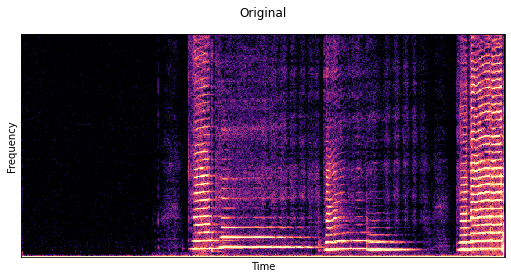

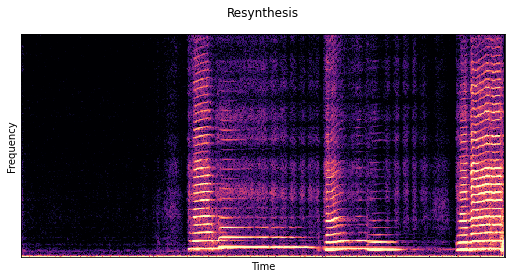

In [17]:
# Resynthesize audio.
outputs = model(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.
# print(outputs.keys())
# dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loundness_db', 
#           'f0_condience', 'loudness_db', 'f0_scaled', 'ld_scaled', 'amps', 
#           'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 
#           'add', 'reverb', 'out', 'audio_synth'])

audio_gen = model.get_audio_from_outputs(outputs)
# Plot
print('Original')
play(audio)
specplot(audio)
plt.title("Original")

print('Resynthesis')
play(audio_gen)
specplot(audio_gen)
_ = plt.title("Resynthesis")